Simulate age and income

In [4]:
import numpy as np

N = 1000

age = holders_index = np.random.randint(16, 75, N)

(array([109., 104., 116.,  98.,  96.,  90.,  96.,  95., 105.,  91.]),
 array([16. , 21.8, 27.6, 33.4, 39.2, 45. , 50.8, 56.6, 62.4, 68.2, 74. ]),
 <a list of 10 Patch objects>)

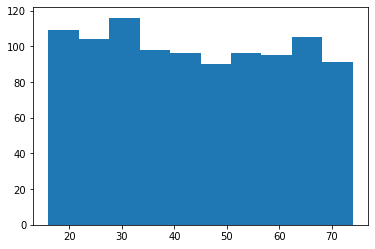

In [5]:
import matplotlib.pyplot as plt

plt.hist(age)

(array([  3.,  21.,  77., 161., 202., 210., 174., 101.,  40.,  11.]),
 array([ -6.29939952,   9.20049257,  24.70038465,  40.20027674,
         55.70016883,  71.20006092,  86.69995301, 102.1998451 ,
        117.69973719, 133.19962927, 148.69952136]),
 <a list of 10 Patch objects>)

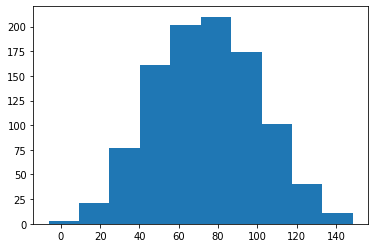

In [6]:
income = age + np.random.normal(30, 20, N)

plt.hist(income)

In [10]:
def calculate_class(age, income):
    if age < 30:
        if income >= 100:
            return 2
        elif income >= 80:
            return 1
        else:
            return 0
    elif age < 50:
        if income >= 90:
            return 2
        elif income >= 70:
            return 1
        else:
            return 0
    elif age < 60:
        if income >= 80:
            return 2
        elif income >= 60:
            return 1
        else:
            return 0
    else:
        if income >= 90:
            return 2
        elif income >= 70:
            return 1
        else:
            return 0



In [21]:
def calculate_response(age):
    if age < 50:
        return 1 if np.random.random() < 0.6 else 0
    else:
        return 1 if np.random.random() < 0.4 else 0

In [22]:
_class = list(map(lambda x, y: calculate_class(x, y), age, income))

In [23]:
response = list(map(lambda x: calculate_response(x), age))

(array([  5.,   8.,  51.,  98., 208., 230., 232., 114.,  36.,  18.]),
 array([17069.80341453, 23006.62260188, 28943.44178923, 34880.26097658,
        40817.08016394, 46753.89935129, 52690.71853864, 58627.537726  ,
        64564.35691335, 70501.1761007 , 76437.99528806]),
 <a list of 10 Patch objects>)

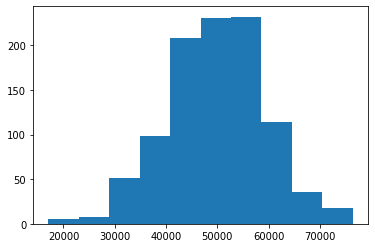

In [40]:
import matplotlib.pyplot as plt

plt.hist(income)

In [25]:
def segmentation(_class, response):
    if _class == 2:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 1:
        if response == 1:
            return 2
        else:
            return 1
    elif _class == 0:
        if response == 1:
            return 1
        else:
            return 0

In [26]:
segment = list(map(lambda x, y: segmentation(x, y), _class, response))

In [27]:
import pandas as pd

data = {'age': age, 'income': income, 'class': _class, 'response': response, 'segment': segment}
df = pd.DataFrame(data)
df

,age,income,class,response,segment
0,40,77.870153,1,1,2
1,48,96.923252,2,0,1
2,68,94.430369,2,0,1
3,64,121.271450,2,1,2
4,33,63.700469,0,1,1
...,...,...,...,...,...
995,43,42.415421,0,1,1
996,70,111.586041,2,0,1
997,42,95.385721,2,1,2
998,67,91.624824,2,0,1


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from nyoka import skl_to_pmml

In [29]:
outputs = df['segment']
inputs = df[['age', 'income', 'class', 'response']]

In [30]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.4, random_state=23)

In [33]:
def build_RF_pipeline(inputs, outputs, rf=None):
    if not rf:
        rf = RandomForestRegressor()
    pipeline = Pipeline([
        ("regressor", rf)
    ])
    pipeline.fit(inputs, outputs)
    return pipeline

In [34]:
def RF_estimation(inputs, outputs,
                  estimator_steps=10,
                  depth_steps=10,
                  min_samples_split=None,
                  min_samples_leaf=None):
    # hyper-parameter estimation
    n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=estimator_steps)]
    max_depth = [int(x) for x in np.linspace(10, 100, num=depth_steps)]
    max_depth.append(None)
    if not min_samples_split:
        min_samples_split = [2, 5, 10]
    if not min_samples_leaf:
        min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid,
                                   n_iter=100, scoring='neg_mean_absolute_error',
                                   cv=3, verbose=1, random_state=42, n_jobs=-1)
    rf_random.fit(inputs, outputs)
    best_random = rf_random.best_estimator_
    print(best_random)
    return best_random

In [35]:
rf = RF_estimation(X_train, y_train, estimator_steps=5, depth_steps=5)
random_forest_pipeline = build_RF_pipeline(X_train, y_train, rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished
RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=650, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [36]:
skl_to_pmml(random_forest_pipeline, ['age', 'income', 'class', 'response'], 'segment',"segmentation.pmml")

the classes_ attribute is to be deprecated from version 0.22 and will be removed in 0.24.
